In [87]:
# 数据处理
import csv
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.0f}'.format
from sklearn.preprocessing import StandardScaler
# 算法
from sklearn.decomposition import PCA
# 评价
from sklearn import metrics
# 绘图
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
from mplfonts import use_font
use_font('Noto Serif CJK CS')
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style({'font.snas-serif':['SimHei']})
plt.rcParams ['font.sans-serif'] = ['SimHei']
plt.rcParams ['axes.unicode_minus'] = False
from tqdm import tqdm # 进度栏
mplstyle.use('fast')

# 数据获取

为了比较聚类结果，使用了两种数据集

In [36]:
# 获取数据（葡萄酒数据）
from sklearn import datasets
wine = datasets.load_wine()
wine_df = pd.DataFrame(wine.data, columns=wine.feature_names) # 转换为数据框架
wine_df.shape
wine_df.head()

# rename
name_list = ['酒精','苹果酸','灰','碱性灰','镁质','总酚含量','黄酮类物质','非黄酮类苯酚','原花青素','颜色强度','色调','稀释值','原氨酸']
wine_df.columns = name_list
wine_df.shape
wine_df.head()

(178, 13)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14,2,2,16,127,3,3,0,2,6,1,4,1065
1,13,2,2,11,100,3,3,0,1,4,1,3,1050
2,13,2,3,19,101,3,3,0,3,6,1,3,1185
3,14,2,2,17,113,4,3,0,2,8,1,3,1480
4,13,3,3,21,118,3,3,0,2,4,1,3,735


(178, 13)

,酒精,苹果酸,灰,碱性灰,镁质,总酚含量,黄酮类物质,非黄酮类苯酚,原花青素,颜色强度,色调,稀释值,原氨酸
0,14,2,2,16,127,3,3,0,2,6,1,4,1065
1,13,2,2,11,100,3,3,0,1,4,1,3,1050
2,13,2,3,19,101,3,3,0,3,6,1,3,1185
3,14,2,2,17,113,4,3,0,2,8,1,3,1480
4,13,3,3,21,118,3,3,0,2,4,1,3,735


In [37]:
# 获取数据（批发商）
wholesale_customers = pd.read_csv("./wholesale_customers_data.csv")

# rename
name_list = ['渠道','地区','新鲜度','牛奶','食品','冷冻食品','洗涤纸','熟食']
wholesale_customers.columns = name_list
wholesale_customers.shape
wholesale_customers.head()

(440, 8)

,渠道,地区,新鲜度,牛奶,食品,冷冻食品,洗涤纸,熟食
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# 数据检查（葡萄酒）

## 缺失值

In [38]:
# 缺失值
missing_values = pd.DataFrame()
for column in wine_df.columns:
    missing_values[column] = [wine_df[wine_df[column].isnull()].shape[0]]
missing_values.T

,0
酒精,0
苹果酸,0
灰,0
碱性灰,0
镁质,0
总酚含量,0
黄酮类物质,0
非黄酮类苯酚,0
原花青素,0
颜色强度,0


# 重复行检查

In [39]:
# 重复行检查
duplicated = pd.DataFrame()
duplicated["重复行数"] = [wine_df[wine_df.duplicated()].shape[0]]
duplicated

,重复行数
0,0


k-means算法很容易受到离群点的影响，所以应该检测和处理离群点。

In [40]:
# 剔除离群点
wine_cut = wine_df.copy()
wine_cut.shape
wine_cut = wine_cut[wine_cut['苹果酸'] < 5.5]
wine_cut.shape
wine_cut = wine_cut[wine_cut['灰'] < 3]
wine_cut.shape
wine_cut = wine_cut[wine_cut['灰'] > 1.5]
wine_cut.shape
wine_cut = wine_cut[wine_cut['镁质'] < 140]
wine_cut.shape
wine_cut = wine_cut[wine_cut['黄酮类物质'] < 3]
wine_cut.shape
wine_cut = wine_cut[wine_cut['颜色强度'] < 12]
wine_cut.shape
wine_cut = wine_cut[wine_cut['色调'] < 1.6]
wine_cut.shape

(178, 13)

(175, 13)

(173, 13)

(172, 13)

(170, 13)

(138, 13)

(137, 13)

(136, 13)

# 数据检查（批发商）

## 缺失值

In [41]:
# 缺失值
missing_values = pd.DataFrame()
for column in wholesale_customers.columns:
    missing_values[column] = [wholesale_customers[wholesale_customers[column].isnull()].shape[0]]
missing_values.T

,0
渠道,0
地区,0
新鲜度,0
牛奶,0
食品,0
冷冻食品,0
洗涤纸,0
熟食,0


## 重复行检查

In [42]:
# 重复行检查
duplicated = pd.DataFrame()
duplicated["重复行数"] = [wholesale_customers[wholesale_customers.duplicated()].shape[0]]
duplicated

,重复行数
0,0


## 剔除离群点

In [43]:
# 剔除离群点
wholesale_cut = wholesale_customers.copy()
wholesale_cut.shape
wholesale_cut = wholesale_cut[wholesale_cut['新鲜度'] < 50000]
wholesale_cut.shape
wholesale_cut = wholesale_cut[wholesale_cut['牛奶'] < 25000]
wholesale_cut.shape
wholesale_cut = wholesale_cut[wholesale_cut['食品'] < 30000]
wholesale_cut.shape
wholesale_cut = wholesale_cut[wholesale_cut['冷冻食品'] < 15000]
wholesale_cut.shape
wholesale_cut = wholesale_cut[wholesale_cut['洗涤纸'] < 20000]
wholesale_cut.shape
wholesale_cut = wholesale_cut[wholesale_cut['熟食'] < 10000]
wholesale_cut.shape

(440, 8)

(433, 8)

(422, 8)

(416, 8)

(408, 8)

(408, 8)

(406, 8)

# 特徴量選択・削除

In [44]:
wholesale_drop = wholesale_cut.copy()
wholesale_drop = wholesale_drop.drop(columns=['渠道', '地区'])
wholesale_drop.head()

,新鲜度,牛奶,食品,冷冻食品,洗涤纸,熟食
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


# 聚类

## 分层聚类

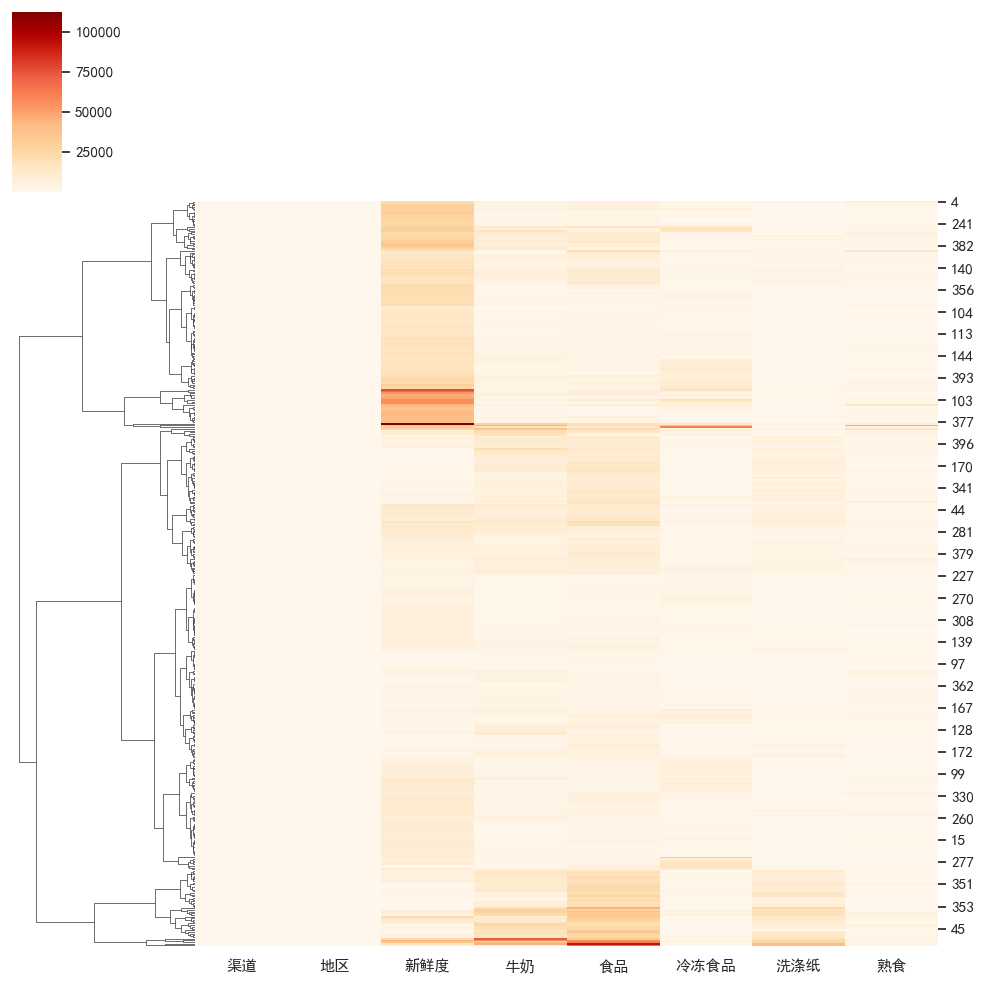

In [62]:
# 热力图
sns.clustermap(wholesale_customers, method='ward', metric='euclidean', col_cluster = False, cmap='OrRd');

In [63]:
plt.rcParams["figure.figsize"] = [15,5]

In [64]:
# 树状图
from scipy.cluster.hierarchy import linkage, dendrogram

def plot_dendrograme(df):
    li=linkage(df.corr())
    r=dendrogram(li, labels=df.columns)
    plt.figure(figsize=[20,5])
    plt.show();

,項目名
0,酒精
1,苹果酸
2,灰
3,碱性灰
4,镁质
5,总酚含量
6,黄酮类物质
7,非黄酮类苯酚
8,原花青素
9,颜色强度


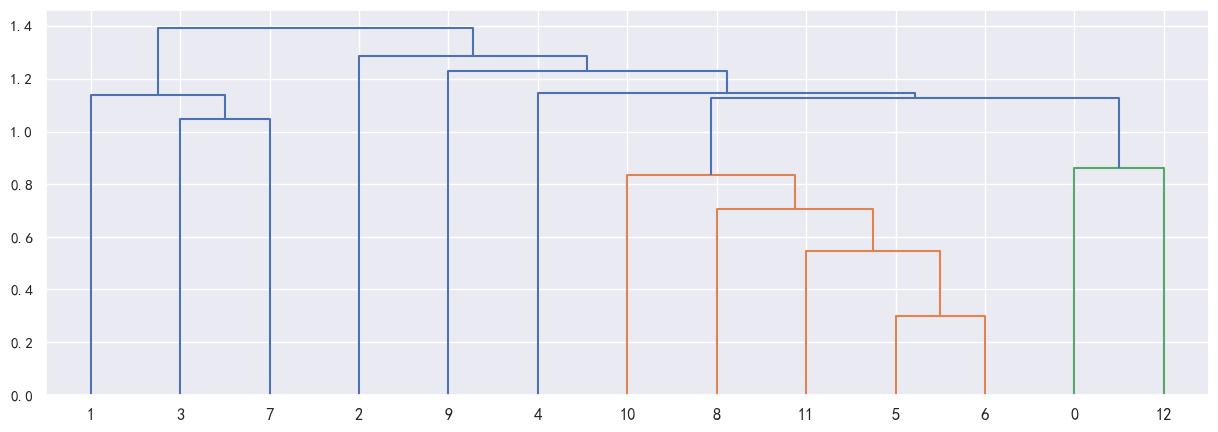

<Figure size 2000x500 with 0 Axes>

In [65]:
# 葡萄酒数据
wine_data = wine_df.copy()
dframe = pd.DataFrame()
dframe['項目名']  = wine_df.columns
dframe

number_list = list(range(0,13))
wine_data.columns = number_list
plot_dendrograme(wine_data)

这种分类似乎是合理的，因为5：总酚也是6：黄酮类化合物的一种类型。
该分类似乎也是正确的，因为7:非黄酮类苯酚位于5:总酚之外。

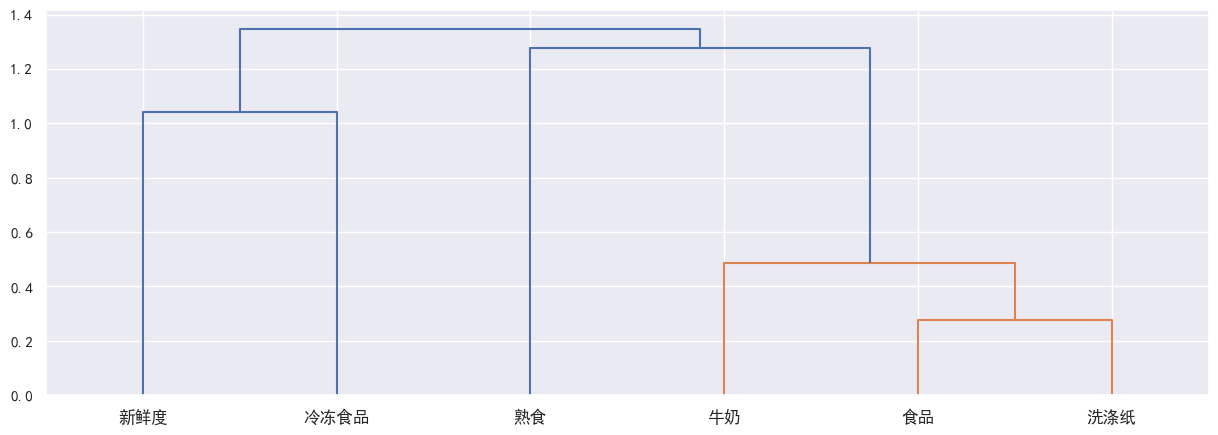

<Figure size 2000x500 with 0 Axes>

In [66]:
# 批发商数据
plot_dendrograme(wholesale_drop)

尽管我预想食品和牛奶的分类会更紧密，但食品和洗涤剂纸的分类更接近。 这可能是因为它们经常被放在一起购买。

## 非层次性聚类

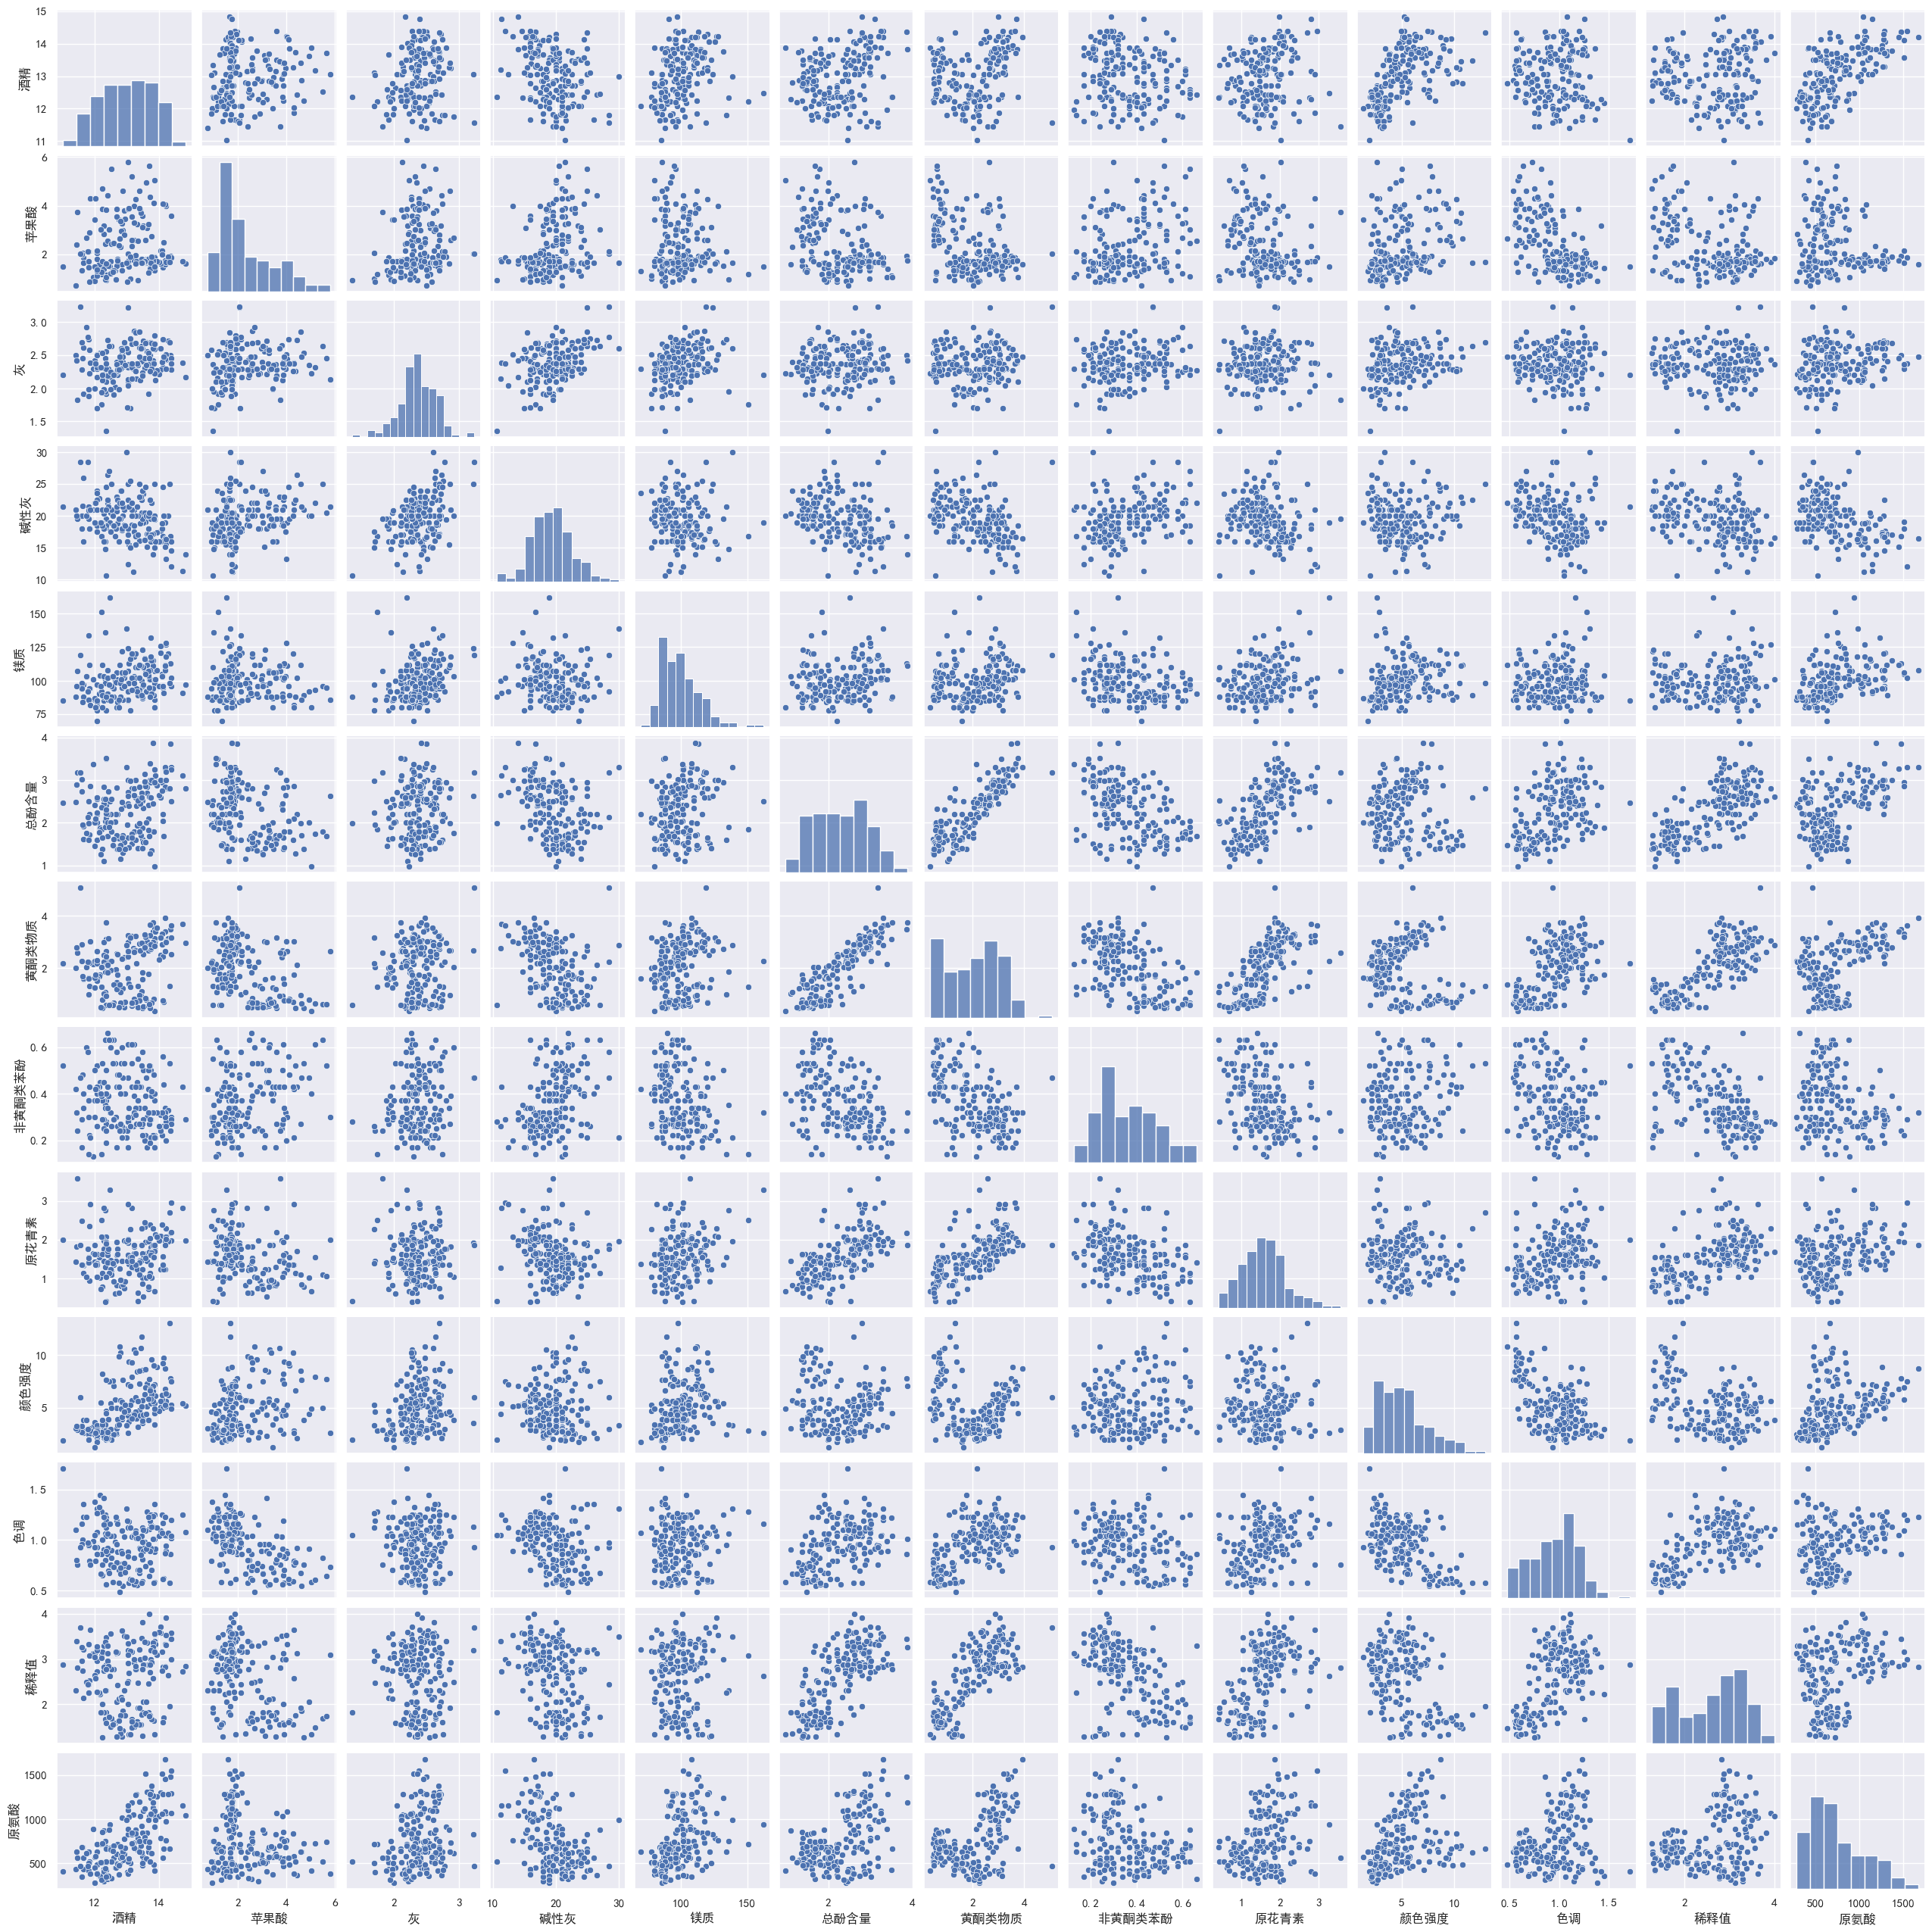

In [68]:
# 散点图矩阵
# 葡萄酒数据
sns.pairplot(wine_df, height=2);

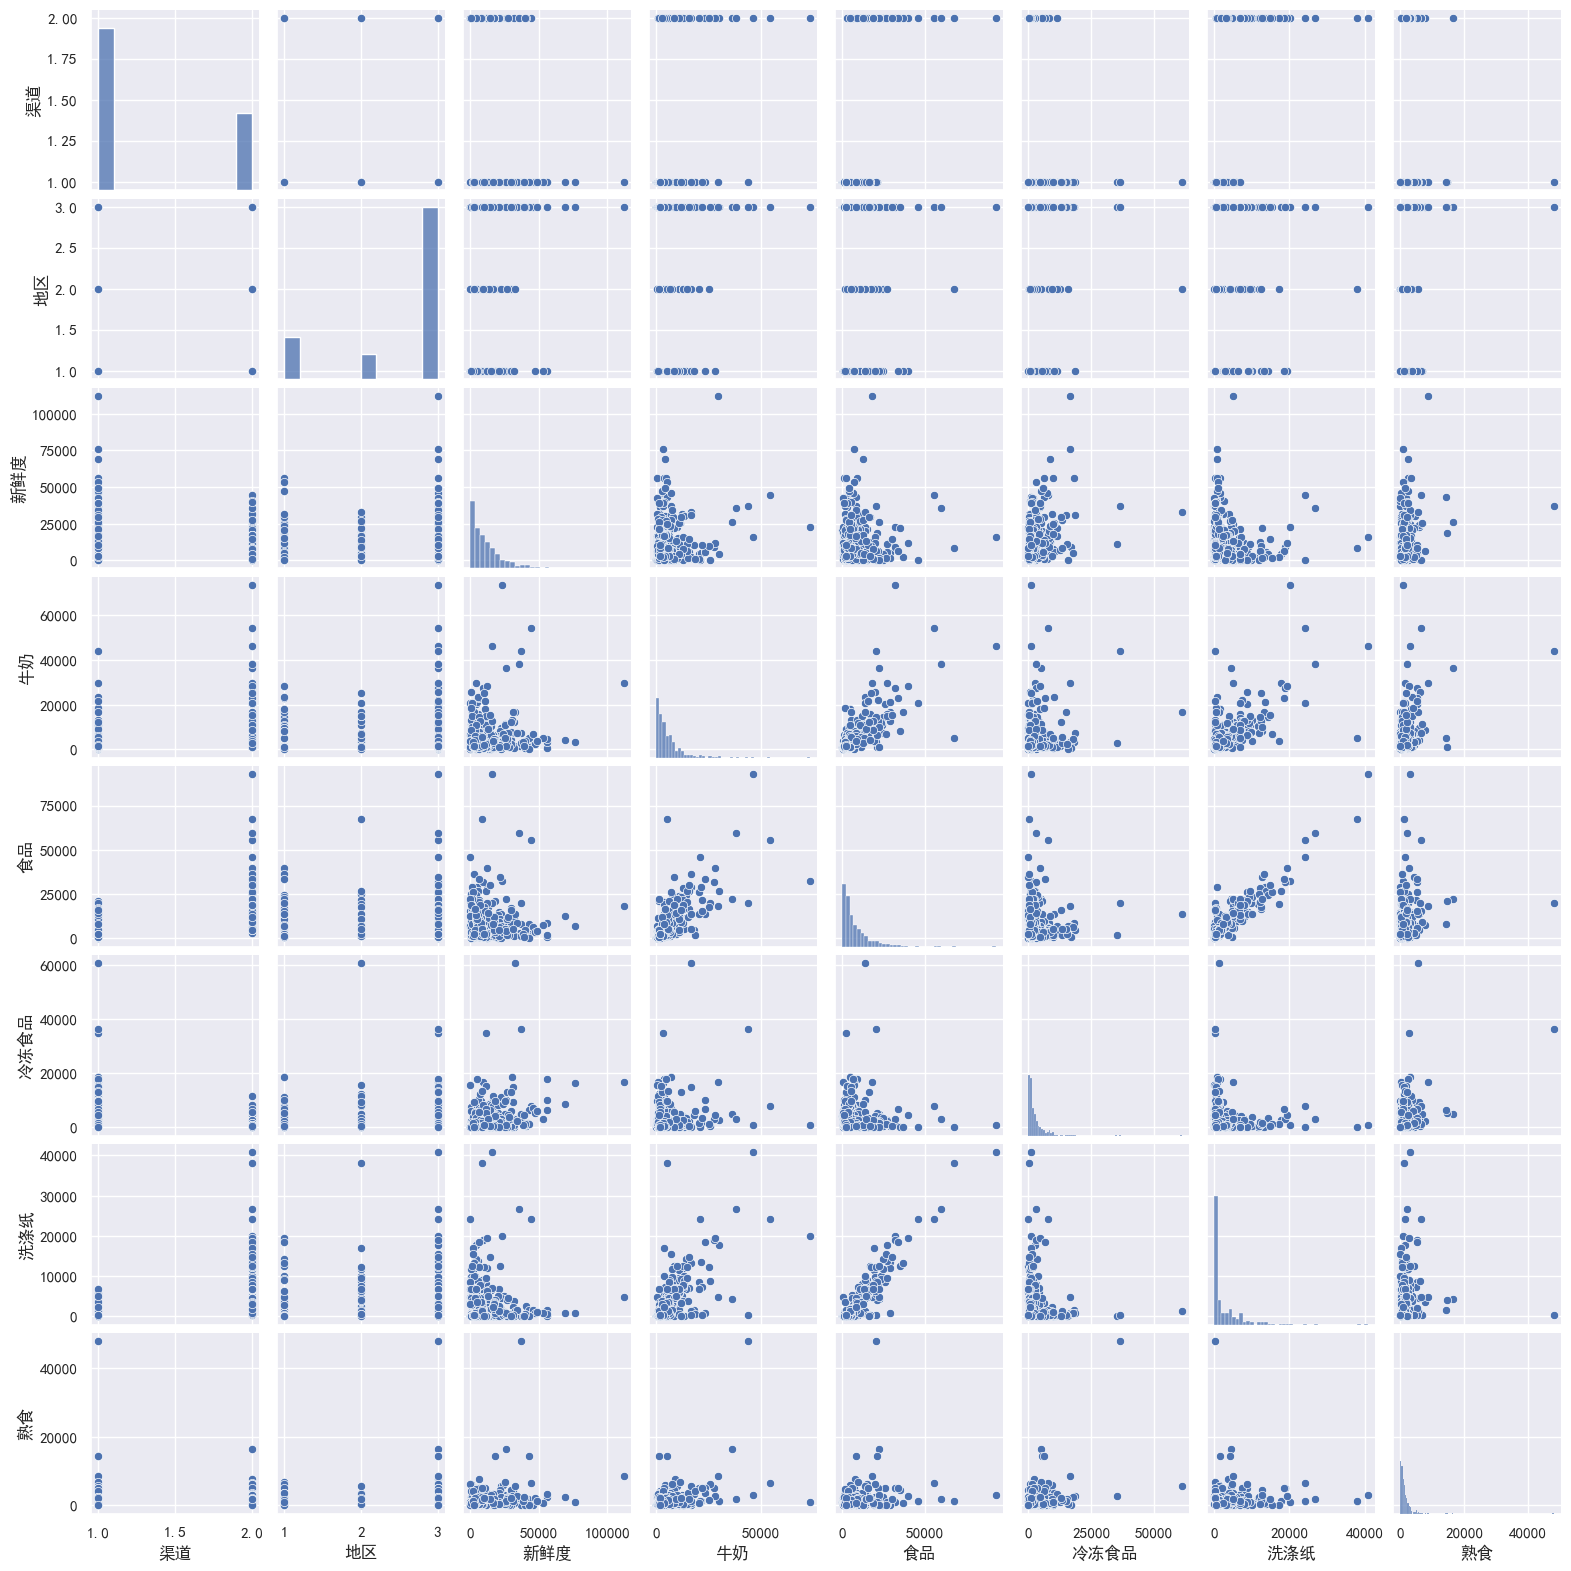

In [69]:
# 散点图矩阵
# 批发商客户（交易）数据
sns.pairplot(wholesale_customers, height=2);

# k-means法

In [88]:
# 聚集（k-means）
from sklearn.cluster import KMeans

def clustering(df, num):
    sc = StandardScaler()
    sc.fit_transform(df)
    data_norm = sc.transform(df)

    cls = KMeans(n_clusters = num)
    result = cls.fit(data_norm)
    pred = cls.fit_predict(data_norm)

    plt.figure(figsize=[10, 5])
    sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})
    sns.scatterplot(x=data_norm[:,0], y=data_norm[:,1], c=result.labels_)
    plt.scatter(result.cluster_centers_[:,0], result.cluster_centers_[:,1], s=250, marker='*', c='blue')
    plt.grid('darkgray')
    plt.show();

## 葡萄酒质量数据

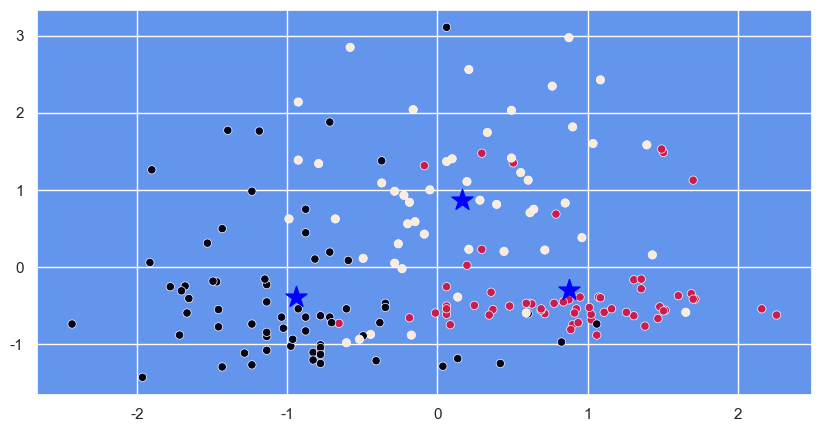

In [89]:
clustering(wine_data, 3)

## 批发商客户（交易）数据

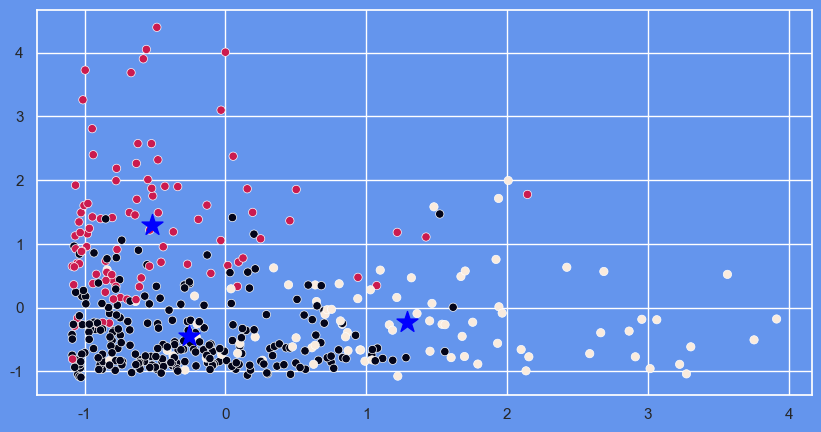

In [84]:
clustering(wholesale_drop, 3)

# elbow method

In [95]:
# 探索聚集的数量
def elbow(df):
    wcss = []

    for i in range(1, 10):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 30, random_state = 0)
        kmeans.fit(df.iloc[:, :])
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=[12,4])
    plt.plot(range(1, 10), wcss)
    plt.title('elbow method')
    plt.xlabel('聚集数',fontproperties='SimHei')
    plt.ylabel('聚集内平方和（SSE）',fontproperties='SimHei')
    plt.grid()
    plt.show();

## 葡萄酒质量数据

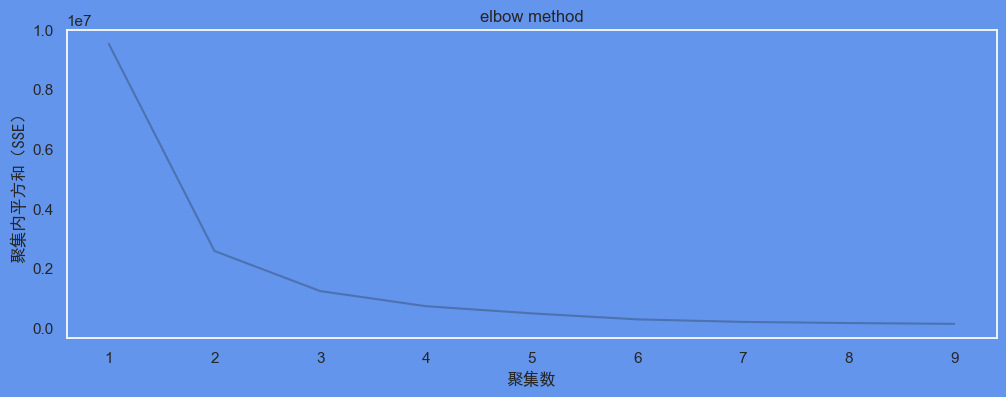

In [96]:
elbow(wine_cut)

可以被分为3-4个群组

## 批发商客户（交易）数据

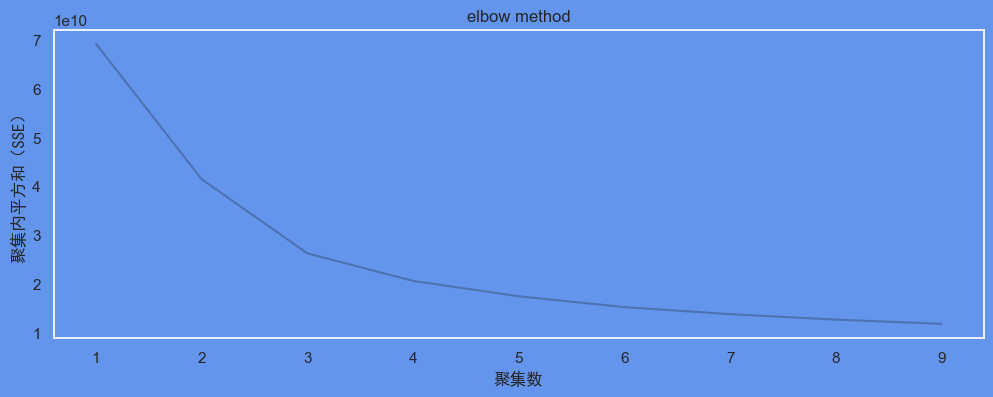

In [97]:
elbow(wholesale_drop)

可以被分为4-5个群组

# 聚类+主成分分析

In [99]:
from sklearn.cluster import KMeans

## 聚类（k-means）+主成分分析
def cross(df, num):
    df_cls = df.copy()
    sc = StandardScaler()
    clustering_sc = sc.fit_transform(df_cls)

    kmeans = KMeans(n_clusters=num, random_state=42) # n_clusters：聚类数
    clusters = kmeans.fit(clustering_sc)
    df_cls['cluster'] = clusters.labels_

    x = clustering_sc
    pca = PCA(n_components=num) # n_components：缩减结果的维数
    pca.fit(x)
    x_pca = pca.transform(x)
    pca_df = pd.DataFrame(x_pca)
    pca_df['cluster'] = df_cls['cluster']

    for i in df_cls['cluster'].unique():
        tmp = pca_df.loc[pca_df['cluster'] == i]
        plt.scatter(tmp[0], tmp[1])
    plt.grid()
    plt.show();

## 葡萄酒质量数据

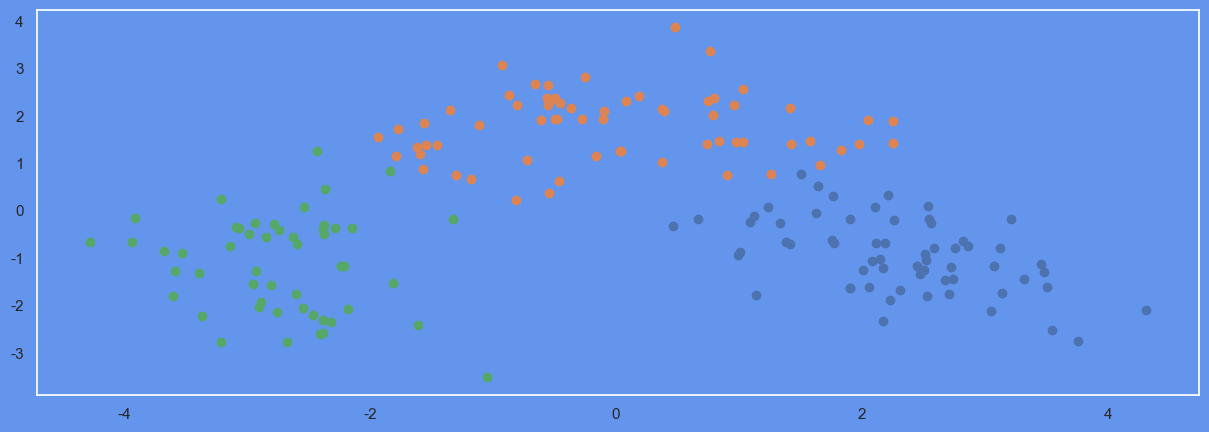

In [100]:
cross(wine_df, 3)

可以看出，葡萄酒质量可以分为三个群组。 
从这一发现，似乎可以进一步分析和讨论每个集群的特点。

## 批发商客户（交易）数据

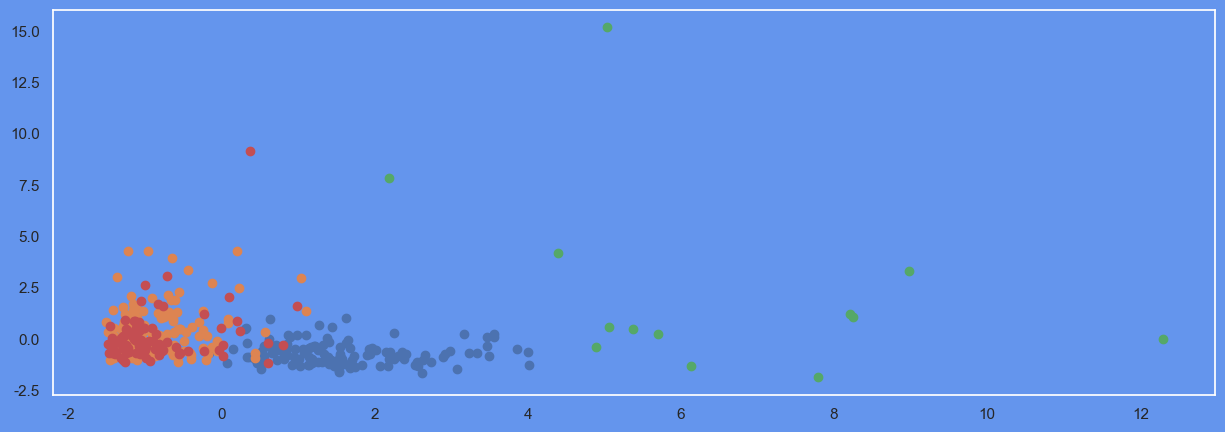

In [101]:
cross(wholesale_customers, 4)

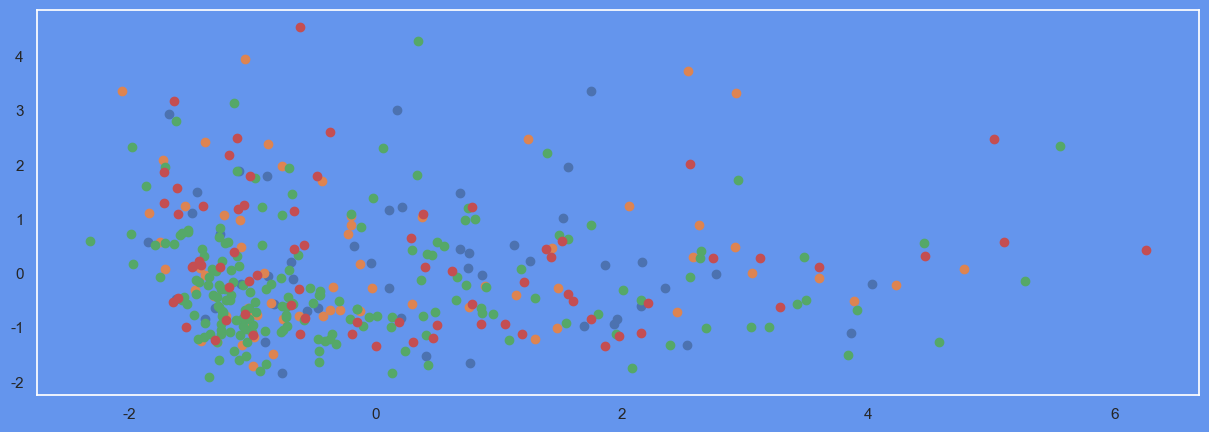

In [102]:
cross(wholesale_drop, 4)

批发商的客户（交易）数据在其他图表中被可视化，因为有许多重叠的元素，集群在散点图中没有得到很好的体现。

## 叠加条形图

In [103]:
def clustering_pred(df):
    sc = StandardScaler()
    sc.fit_transform(df)
    data_norm = sc.transform(df)

    cls = KMeans(n_clusters = 4)
    pred = cls.fit_predict(data_norm)

    df['聚类ID']=pred
    
    return df

In [104]:
result = clustering_pred(wholesale_drop)
result.head()

,新鲜度,牛奶,食品,冷冻食品,洗涤纸,熟食,聚类ID
0,12669,9656,7561,214,2674,1338,1
1,7057,9810,9568,1762,3293,1776,1
2,6353,8808,7684,2405,3516,7844,1
3,13265,1196,4221,6404,507,1788,2
4,22615,5410,7198,3915,1777,5185,1


<Figure size 2000x500 with 0 Axes>

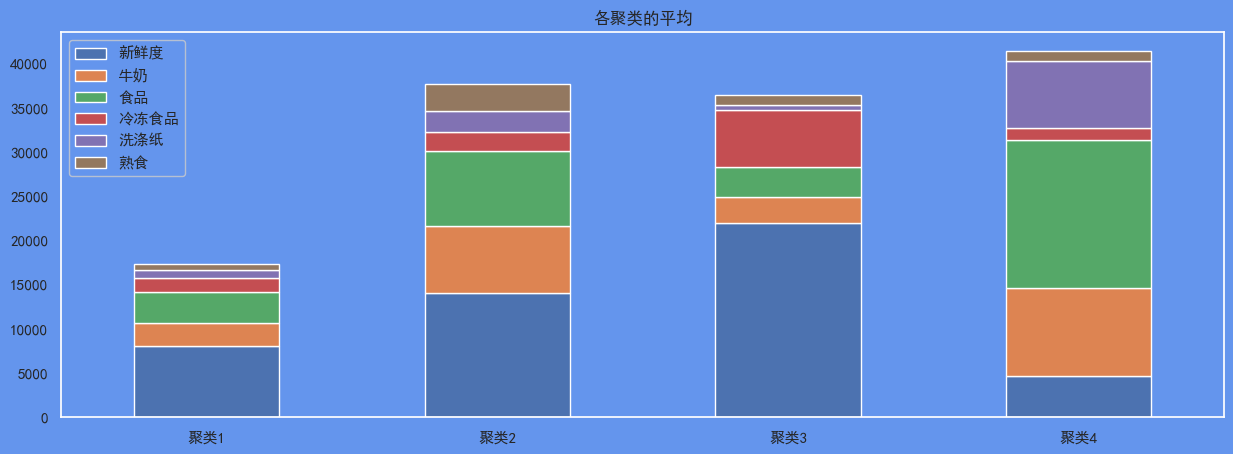

In [111]:
# 叠加条形图
cluster = pd.DataFrame()
for i in range(4):
    cluster['聚类' + str(i+1)] = wholesale_drop[wholesale_drop['聚类ID'] == i].mean()
cluster = cluster.drop('聚类ID')

plt.figure(figsize=[20,5])
my_plot = cluster.T.plot(kind='bar', stacked=True, title="各聚类的平均")
my_plot.set_xticklabels(my_plot.xaxis.get_majorticklabels(), rotation=0)
plt.rcParams['font.sans-serif']=['SimHei']
plt.grid();

叠加条形图的可视化使每个细分市场（客户）的组成部分被理解。 
逐个细分市场的可视化显示，每个集群的每个组成部分（每个变量）的比例是不同的。 
  
群组1：新鲜度、食品杂货和牛奶  
群组2：新鲜度、杂货、牛奶、洗洁精纸、比重较小  
第3组：新鲜度，比重较小　　
第4组：食品杂货、冷冻  

# K-Means++法

In [112]:
# 聚类（KMeans++）＋主成分分析
def cross(df, num):
    sc = StandardScaler()

    df_cls = df.copy()
    clustering_sc = sc.fit_transform(df_cls)

    kmeans = KMeans(n_clusters=num, # n_clusters：聚类数
                    init='k-means++', # 设置中心，使用k-means++方法选择中心店点（中心点）的初始值。
                    n_init=10, # 不同初始值的运行数量
                    max_iter=1000, # 最大迭代次数 default: '300'
                    tol=1e-04, # 允许的误差
                    random_state=42
                    )
    clusters = kmeans.fit(clustering_sc)
    df_cls['cluster'] = clusters.labels_

    x = clustering_sc
    pca = PCA(n_components=num) # n_components：缩减结果的维数
    pca.fit(x)
    x_pca = pca.transform(x)
    pca_df = pd.DataFrame(x_pca)
    pca_df['cluster'] = df_cls['cluster']

    for i in df_cls['cluster'].unique():
        tmp = pca_df.loc[pca_df['cluster'] == i]
        plt.scatter(tmp[0], tmp[1])
    plt.grid()
    plt.show();

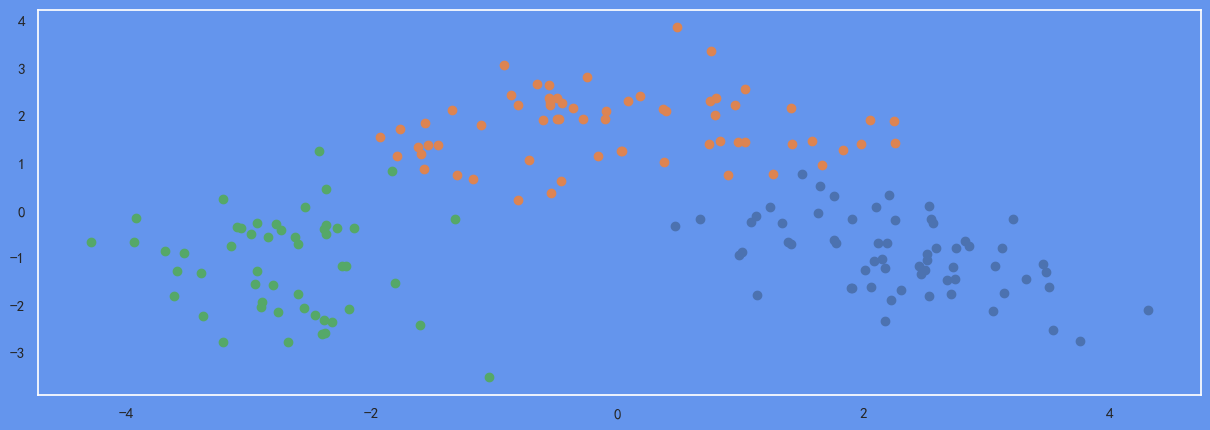

In [113]:
cross(wine_df, 3)

在'k-means ⇆ k-means'之间没有发现太大的差异，可能是由于数据集的简单性。

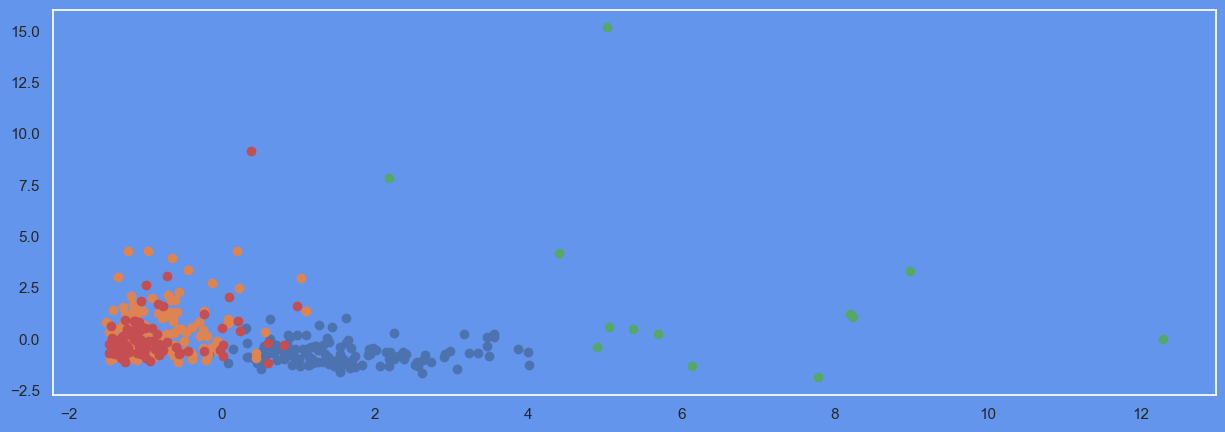

In [33]:
cross(wholesale_customers, 4)

不排除异常值的结果。 
虽然这里也有很多重叠的元素，但在'k-means ⇆ k-means'中没有发现明显的差异，可能是因为样本量小，数据简单。

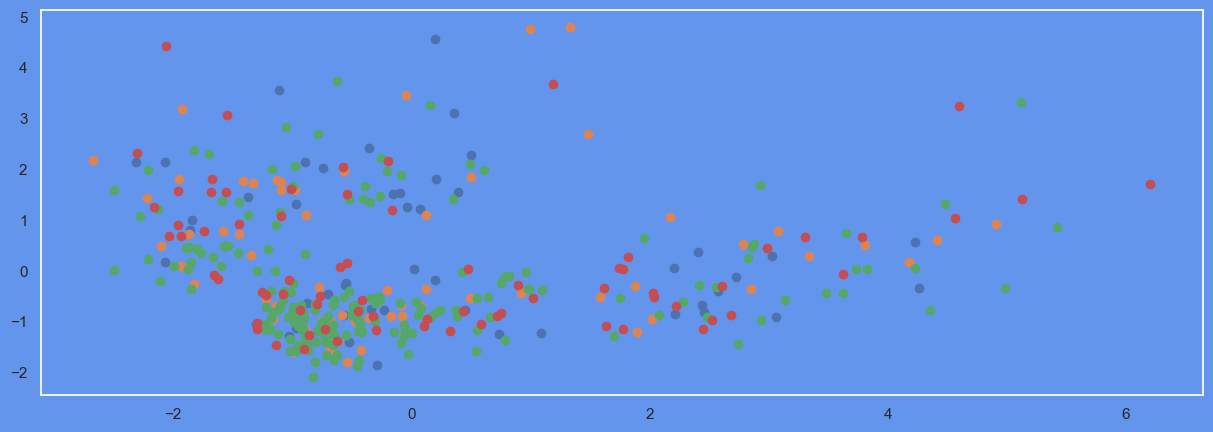

In [34]:
cross(wholesale_drop, 4)

排除异常值的结果。 
批发商客户（交易）数据仍然不可能在平面上进行分组。 
为了分析每个细分市场的组成部分，叠加条形图的可视化仍然是有效的。 

# 特征生成

In [114]:
# 与重心的距离
num_cluster=3 # cluster数
clusters = KMeans(n_clusters=num_cluster, random_state = 42)
clusters.fit(wine_cut)
centers = clusters.cluster_centers_

columns = wine_cut.columns
clust_features = pd.DataFrame(index = wine_cut.index)
for i in range(len(centers)):
    clust_features['与cluster' + str(i + 1) + '的距离'] = (wine_cut[columns] - centers[i]).applymap(abs).apply(sum, axis = 1)

clust_features

KMeans(n_clusters=3, random_state=42)

,与cluster1的距离,与cluster2的距离,与cluster3的距离
1,613,106,351
4,306,428,45
6,848,161,592
7,874,170,610
8,605,112,348
...,...,...,...
172,213,511,71
174,310,411,46
175,415,340,150
176,418,332,152
